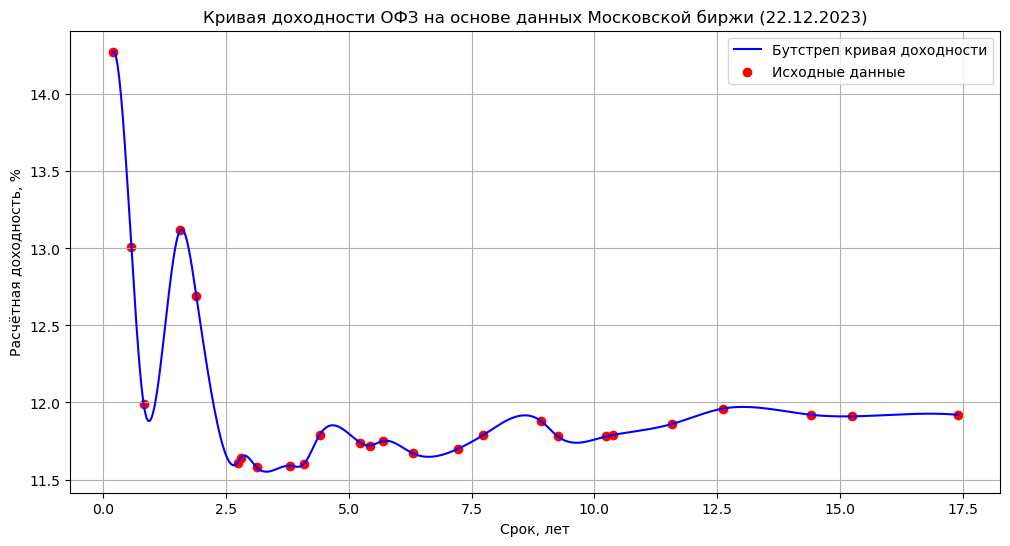

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.interpolate import CubicSpline

# Загрузка данных из файла Excel
file_path = 'D:\\b.xlsx'  
data = pd.read_excel(file_path)

# Преобразование даты погашения в срок (в годах)
current_date = datetime(2023, 12, 22)
data['Дата погашения'] = pd.to_datetime(data['Дата погашения'])
data['Срок, лет'] = (data['Дата погашения'] - current_date).dt.days / 365

# Выбор столбцов сроков и доходностей
terms = data['Срок, лет']
rates = data['Расчётная доходность']

# Определение функции для бутстрепа кривой доходности
def bootstrap_yield_curve(terms, rates):
    # Используем кубический сплайн для интерполяции между точками
    cs = CubicSpline(terms, rates)
    return cs

# Создание кривой доходности с помощью бутстрепа
yield_curve = bootstrap_yield_curve(terms, rates)

# Генерация значений для графика
terms_fine = np.linspace(terms.min(), terms.max(), 500)
rates_fine = yield_curve(terms_fine)

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(terms_fine, rates_fine, label='Бутстреп кривая доходности', color='blue')
plt.scatter(terms, rates, color='red', label='Исходные данные')
plt.title('Кривая доходности ОФЗ на основе данных Московской биржи (22.12.2023)')
plt.xlabel('Срок, лет')
plt.ylabel('Расчётная доходность, %')
plt.legend()
plt.grid(True)
plt.show()


#Планируется дальнейшая разработка модели. 

In [15]:
# Импорт необходимых библиотек для дополнения и анализа модели
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Функция для расчета стандартной ошибки интерполяции
def calculate_standard_error(terms, rates, spline):
    predicted_rates = spline(terms)
    return np.sqrt(np.mean((rates - predicted_rates) ** 2))

# Функция для оценки гладкости кривой (вычисление второй производной)
def evaluate_smoothness(spline, terms):
    second_derivatives = spline(terms, 2)
    return np.max(np.abs(second_derivatives))

# Функция для проверки наличия отрицательных форвардных ставок
def check_negative_forward_rates(spline, terms):
    forward_rates = spline(terms)
    return np.any(forward_rates < 0)

# Функция для оценки стабильности модели
def evaluate_stability(terms, rates, delta=0.01):
    original_spline = CubicSpline(terms, rates)
    perturbed_rates = rates + np.random.normal(0, delta, size=rates.shape)
    perturbed_spline = CubicSpline(terms, perturbed_rates)
    original_values = original_spline(terms)
    perturbed_values = perturbed_spline(terms)
    return np.max(np.abs(original_values - perturbed_values))

# Преобразование даты погашения в срок (в годах)
current_date = datetime.now()
data['Дата погашения'] = pd.to_datetime(data['Дата погашения'])
data['Срок, лет'] = (data['Дата погашения'] - current_date).dt.days / 365

# Выбор столбцов сроков и доходностей
terms = data['Срок, лет']
rates = data['Расчётная доходность']

# Создание кривой доходности с помощью бутстрепа
yield_curve = CubicSpline(terms, rates)

# Расчет критериев для оценки модели
std_error = calculate_standard_error(terms, rates, yield_curve)
smoothness = evaluate_smoothness(yield_curve, terms)
negative_forward_rates = check_negative_forward_rates(yield_curve, terms)
stability = evaluate_stability(terms, rates)

# Количество параметров в модели (равно количеству точек данных)
simplicity = len(terms)

# Отображение результатов
results = {
    "Стандартная ошибка": std_error,
    "Гладкость": smoothness,
    "Отрицательные форвардные ставки": negative_forward_rates,
    "Стабильность": stability,
    "Простота реализации (количество параметров)": simplicity
}

results


{'Стандартная ошибка': 0.0,
 'Гладкость': 31.537434827478457,
 'Отрицательные форвардные ставки': False,
 'Стабильность': 0.025150530306630614,
 'Простота реализации (количество параметров)': 26}

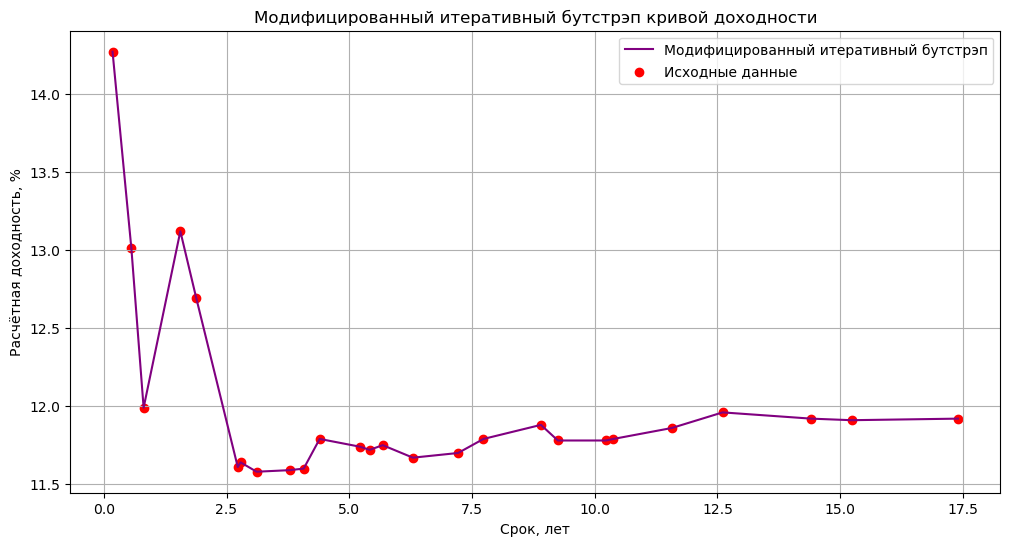

In [16]:
# Модифицированная функция для итеративного бутстрэпа
def modified_iterative_bootstrap_yield_curve(terms, rates, iterations):
    bootstrap_rates = np.array(rates)

    for iteration in range(iterations):
        # Интерполируем кривую на текущей итерации
        cs = CubicSpline(terms, bootstrap_rates)
        
        # Обновляем значения на основе интерполированной кривой
        bootstrap_rates = cs(terms)

    return bootstrap_rates

# Количество итераций для модифицированного итеративного бутстрэпа
iterations = 10

# Выполнение модифицированного итеративного бутстрэпа
modified_iterative_bootstrap_rates = modified_iterative_bootstrap_yield_curve(terms, rates, iterations)

# Построение графика модифицированного итеративного бутстрэпа
plt.figure(figsize=(12, 6))
plt.plot(terms, modified_iterative_bootstrap_rates, label='Модифицированный итеративный бутстрэп', color='purple')
plt.scatter(terms, rates, color='red', label='Исходные данные')
plt.title('Модифицированный итеративный бутстрэп кривой доходности')
plt.xlabel('Срок, лет')
plt.ylabel('Расчётная доходность, %')
plt.legend()
plt.grid(True)
plt.show()


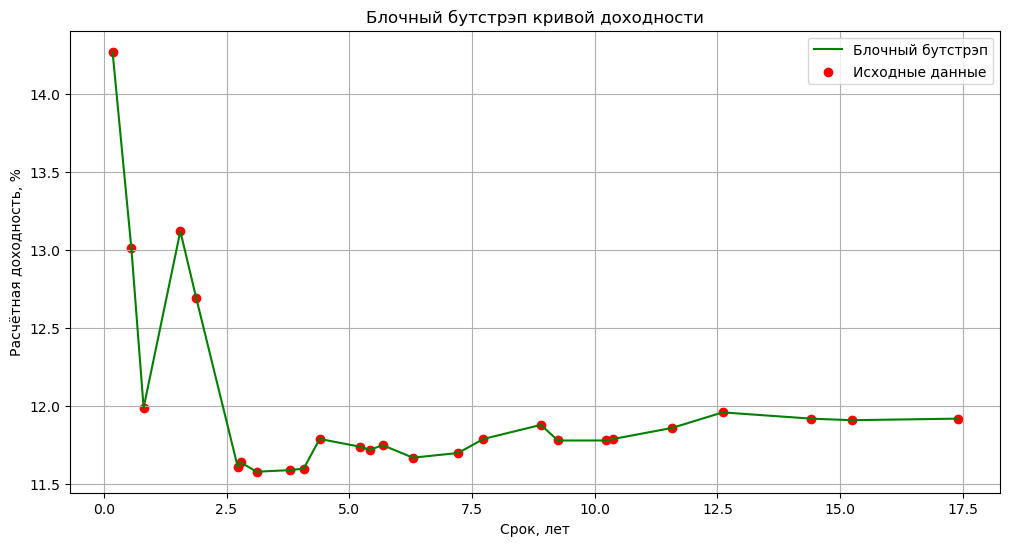

In [18]:
# Функция для блочного бутстрэпа
def block_bootstrap_yield_curve(terms, rates, block_size):
    # Определение числа блоков
    num_blocks = int(np.ceil(len(terms) / block_size))
    bootstrap_rates = np.zeros_like(rates)

    for i in range(num_blocks):
        start_index = i * block_size
        end_index = min((i + 1) * block_size, len(terms))
        block_terms = terms[start_index:end_index]
        block_rates = rates[start_index:end_index]

        # Интерполяция внутри каждого блока
        if len(block_terms) > 1:
            cs = CubicSpline(block_terms, block_rates)
            bootstrap_rates[start_index:end_index] = cs(block_terms)

    return bootstrap_rates

# Размер блока для блочного бутстрэпа
block_size = 6

# Выполнение блочного бутстрэпа
block_bootstrap_rates = block_bootstrap_yield_curve(terms, rates, block_size)

# Построение графика блочного бутстрэпа
plt.figure(figsize=(12, 6))
plt.plot(terms, block_bootstrap_rates, label='Блочный бутстрэп', color='green')
plt.scatter(terms, rates, color='red', label='Исходные данные')
plt.title('Блочный бутстрэп кривой доходности')
plt.xlabel('Срок, лет')
plt.ylabel('Расчётная доходность, %')
plt.legend()
plt.grid(True)
plt.show()
